1. Mô tả bài toán
Retail Store Inventory & Demand Forecasting (ML cơ bản)
Mục tiêu đề tài
- Bài toán 1 (Regression): Dự đoán Demand (nhu cầu ước tính hàng ngày cho sản phẩm).
- Bài toán 2 (Classification): Dự đoán*nguy cơ hết hàng (Stockout).
Phạm vi dữ liệu
- Dữ liệu bán lẻ theo ngày, gồm nhiều cửa hàng (Store ID) và sản phẩm (Product ID).
- Có các yếu tố giá, giảm giá, khuyến mãi, thời tiết, mùa vụ, dịch bệnh, giá đối thủ…



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

df = pd.read_csv(r"C:\Users\Admin\AdvancedPython\12423030_12423TN_HoangThiMinhTam\data\sales_data.csv")
df.head()

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values(["Store ID", "Product ID", "Date"]).reset_index(drop=True)

print("Kích thước dữ liệu:", df.shape)
print("Số dòng Date lỗi (NaT):", df["Date"].isna().sum())
print("Khoảng thời gian:", df["Date"].min(), "->", df["Date"].max())


Kích thước dữ liệu: (76000, 16)
Số dòng Date lỗi (NaT): 0
Khoảng thời gian: 2022-01-01 00:00:00 -> 2024-01-30 00:00:00


2. Mô tả dữ liệu
Các biến dùng để phân nhóm, so sánh theo đặc trưng định tính, thường cần mã hoá (Encoding) trước khi đưa vào mô hình.
- Store ID: Mã định danh duy nhất cho từng cửa hàng.
- Product ID: Mã định danh duy nhất cho từng sản phẩm.
- Category: Danh mục sản phẩm (ví dụ: thực phẩm, đồ gia dụng, thời trang…).
- Region: Khu vực địa lý nơi cửa hàng hoạt động.
- Weather Condition: Điều kiện thời tiết tại thời điểm ghi nhận dữ liệu.
- Seasonality: Yếu tố mùa vụ trong năm (ví dụ: Xuân, Hạ, Thu, Đông).

Biến thời gian thường được xử lý riêng để trích xuất đặc trưng.
- Date: Ngày ghi nhận dữ liệu, có thể dùng để sinh thêm các biến như ngày trong tuần, tháng, mùa cao điểm,…

Các biến biểu diễn trạng thái có/không, thường được mã hoá dưới dạng 0–1.
- Promotion:
    1: Có chương trình khuyến mãi (giảm giá, quà tặng…).
    0: Không có khuyến mãi.
- Epidemic:
    1: Có yếu tố dịch bệnh ảnh hưởng.
    0: Không có dịch bệnh.

Các biến định lượng, dùng trực tiếp cho phân tích thống kê, EDA và xây dựng mô hình dự báo.
- Inventory Level: Số lượng hàng tồn kho tại cửa hàng.
- Units Sold: Số lượng sản phẩm bán ra trong ngày.
- Units Ordered: Số lượng sản phẩm được đặt thêm để nhập kho.
- Price: Giá bán của sản phẩm.
- Discount: Mức giảm giá được áp dụng (nếu có).
- Competitor Pricing: Giá sản phẩm tương tự của đối thủ cạnh tranh.
- Demand: Nhu cầu ước tính hàng ngày đối với sản phẩm (biến mục tiêu trong bài toán dự báo).


In [5]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-02,S001,P0001,Electronics,North,93,71,0,65.63,5,Snowy,0,73.66,Winter,0,84
2,2022-01-03,S001,P0001,Electronics,North,274,142,229,68.55,15,Snowy,1,80.73,Winter,0,132
3,2022-01-04,S001,P0001,Electronics,North,132,42,0,61.66,10,Snowy,0,54.88,Winter,0,67
4,2022-01-05,S001,P0001,Electronics,North,319,129,0,59.56,25,Snowy,1,57.34,Winter,0,110


In [6]:
df.shape

(76000, 16)

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                76000 non-null  datetime64[ns]
 1   Store ID            76000 non-null  object        
 2   Product ID          76000 non-null  object        
 3   Category            76000 non-null  object        
 4   Region              76000 non-null  object        
 5   Inventory Level     76000 non-null  int64         
 6   Units Sold          76000 non-null  int64         
 7   Units Ordered       76000 non-null  int64         
 8   Price               76000 non-null  float64       
 9   Discount            76000 non-null  int64         
 10  Weather Condition   76000 non-null  object        
 11  Promotion           76000 non-null  int64         
 12  Competitor Pricing  76000 non-null  float64       
 13  Seasonality         76000 non-null  object    

In [8]:
print(df.describe())

                      Date  Inventory Level    Units Sold  Units Ordered  \
count                76000     76000.000000  76000.000000   76000.000000   
mean   2023-01-15 12:00:00       301.062842     88.827316      89.090645   
min    2022-01-01 00:00:00         0.000000      0.000000       0.000000   
25%    2022-07-09 18:00:00       136.000000     58.000000       0.000000   
50%    2023-01-15 12:00:00       227.000000     84.000000       0.000000   
75%    2023-07-24 06:00:00       408.000000    114.000000     121.000000   
max    2024-01-30 00:00:00      2267.000000    426.000000    1616.000000   
std                    NaN       226.510161     43.994525     162.404627   

              Price      Discount     Promotion  Competitor Pricing  \
count  76000.000000  76000.000000  76000.000000        76000.000000   
mean      67.726028      9.087039      0.328947           69.454029   
min        4.740000      0.000000      0.000000            4.290000   
25%       31.997500      5.0000

In [9]:
#Phân loại cột
date_col = "Date"

cat_cols = ["Store ID","Product ID","Category","Region","Weather Condition","Seasonality"]
bin_cols = ["Promotion","Epidemic"]   # true false
num_cols = ["Inventory Level","Units Sold","Units Ordered","Price","Discount","Competitor Pricing","Demand"]

print("Categorical:", cat_cols)
print("Binary:", bin_cols)
print("Numeric:", num_cols)

Categorical: ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']
Binary: ['Promotion', 'Epidemic']
Numeric: ['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Competitor Pricing', 'Demand']


3. Kiểm tra dữ liệu

In [10]:
#kiểm tra dòng trung lặp
print("Duplicate full rows:", df.duplicated().sum())

Duplicate full rows: 0


In [11]:
#kiểm tra bộ khóa trùng lặp
key_cols = ["Date", "Store ID", "Product ID"]
dup_key = df.duplicated(subset=key_cols).sum()
dup_key

np.int64(0)

In [12]:
#Kiểm tra outliers
region_col = "Region"
store_col = "Store ID"
product_col = "Product ID"
price_col = "Price"

# Tính giá trung bình theo (Region, Product, Store)
grouped = (
    df.groupby([region_col, product_col, store_col])[price_col]
      .mean()
      .reset_index()
)

problematic_idx = pd.Index([])

# Với mỗi (Region, Product) bắt store có giá outlier theo IQR
for (region, product), g in grouped.groupby([region_col, product_col]):
    prices = g[price_col].values

    # kiểm tra khi có từ 2 store trở lên
    if len(prices) <= 1:
        continue

    q1 = np.percentile(prices, 25)
    q3 = np.percentile(prices, 75)
    iqr = q3 - q1

    # nếu iqr = 0 thì không có outlier 
    if iqr == 0:
        continue

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outlier_stores = g.loc[(g[price_col] < lower) | (g[price_col] > upper), store_col].tolist()

    if len(outlier_stores) > 0:
        mask = (
            (df[region_col] == region) &
            (df[product_col] == product) &
            (df[store_col].isin(outlier_stores))
        )
        problematic_idx = problematic_idx.union(df.loc[mask].index)

print(len(problematic_idx))


0


In [13]:
df[cat_cols].nunique()

Store ID              5
Product ID           20
Category              5
Region                4
Weather Condition     4
Seasonality           4
dtype: int64

4. Chuẩn hóa dữ liệu

In [14]:
#định dạng ngày tháng y-m-d
df["Date"] = pd.to_datetime(
    df["Date"].astype(str).str.strip(),
    format="%Y-%m-%d",
    errors="coerce"
)

print("dtype:", df["Date"].dtype)
df[["Date"]].head(10)

dtype: datetime64[ns]


,Date
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05
5,2022-01-06
6,2022-01-07
7,2022-01-08
8,2022-01-09
9,2022-01-10


5. Trực quan hóa dữ liệu
5.1 Phân phối dữ liệu
- Phân phối lệch phải
- Phần lớn Demand tập trung quanh ~80–130
- Có đuôi dài kéo tới >300 => tồn tại các ngày cầu rất cao
=> Nhu cầu bình thường ổn định, nhưng thỉnh thoảng có đợt bùng cầu (promotion, mùa vụ, sự kiện)

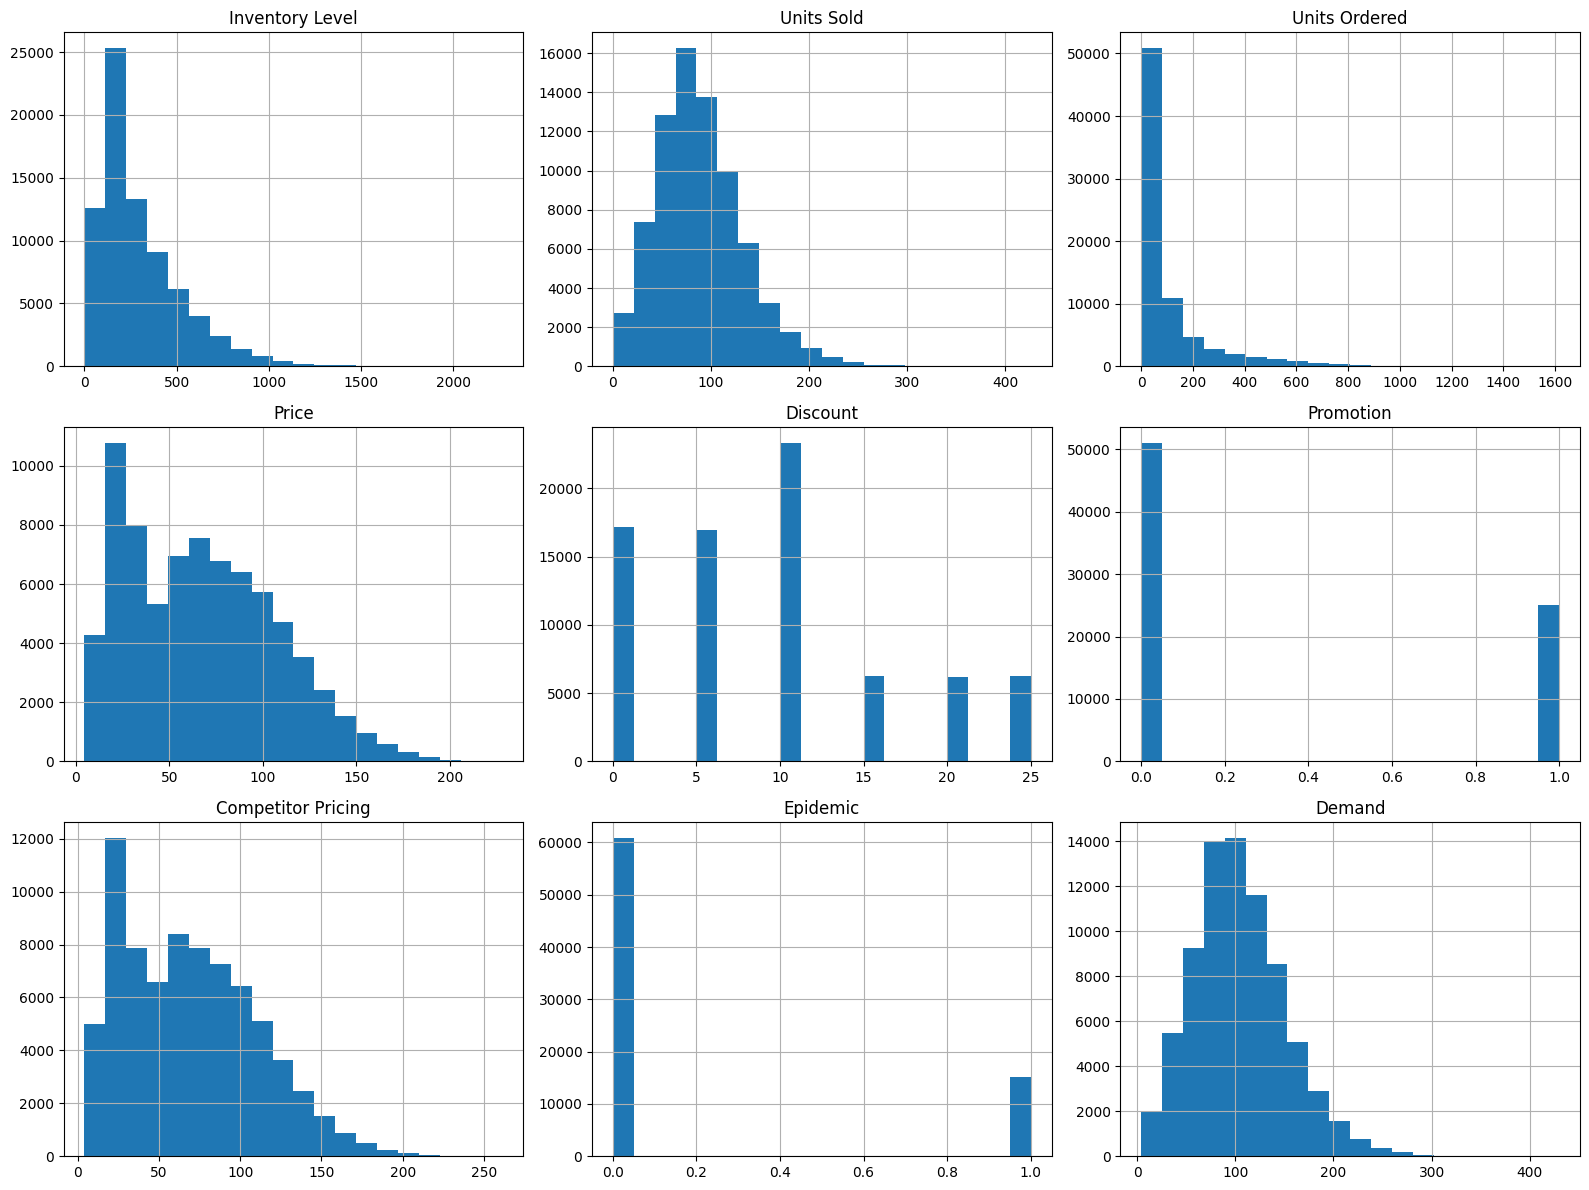

In [15]:
numeric_cols = df.select_dtypes(include='number').columns

df[numeric_cols].hist(
    bins=20,
    figsize=(16, 12),
    layout=None
)

plt.tight_layout()
plt.show()

5.2 Phân tích theo nghiệp vụ

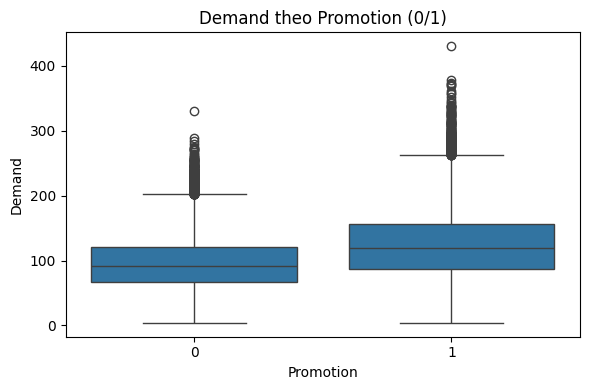

In [16]:
# Demand vs Promotion
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Promotion", y="Demand")
plt.title("Demand theo Promotion (0/1)")
plt.xlabel("Promotion")
plt.ylabel("Demand")
plt.tight_layout()
plt.show()

Nhóm Promotion = 1 có median cao hơn so với Promotion = 0 
Khuyến mãi kéo nhu cầu tăng, đồng thời làm nhu cầu dao động mạnh hơn

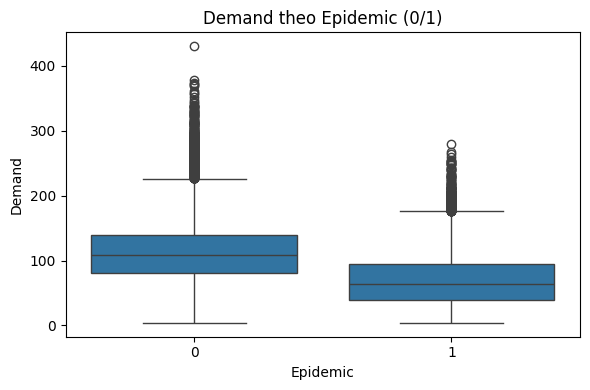

In [17]:
# Demand vs Epidemic
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Epidemic", y="Demand")
plt.title("Demand theo Epidemic (0/1)")
plt.xlabel("Epidemic")
plt.ylabel("Demand")
plt.tight_layout()
plt.show()

Nhóm Epidemic = 1 có median thấp hơn hẳn Epidemic = 0
Dịch bệnh là một shock làm nhu cầu giảm (hoặc thay đổi hành vi mua sắm)

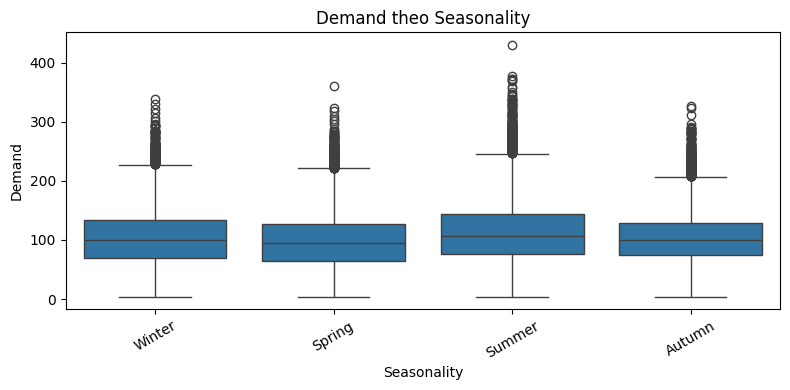

In [18]:
# Demand vs Seasonality
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="Seasonality", y="Demand")
plt.title("Demand theo Seasonality")
plt.xlabel("Seasonality")
plt.ylabel("Demand")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Các mùa có median khác nhau
Mùa Summer có median cao hơn => nhu cầu có thay đổi theo mùa

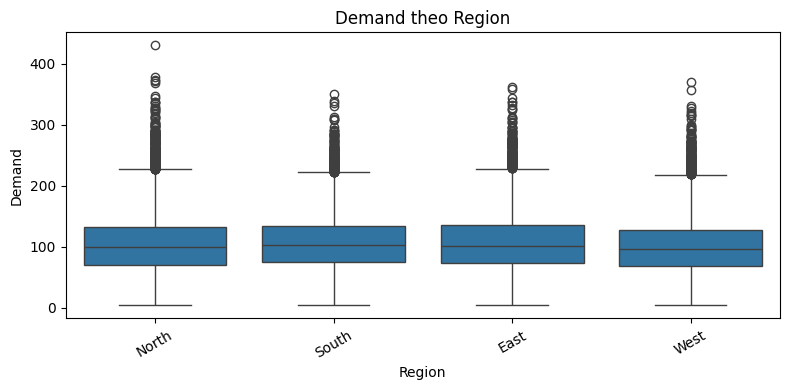

In [19]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="Region", y="Demand")
plt.title("Demand theo Region")
plt.xlabel("Region")
plt.ylabel("Demand")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Các vùng có median khá gần nhau, chênh lệch không quá lớn
Region không ảnh hưởng hoàn toàn nhưng vẫn phản ánh khác biệt thị trường.

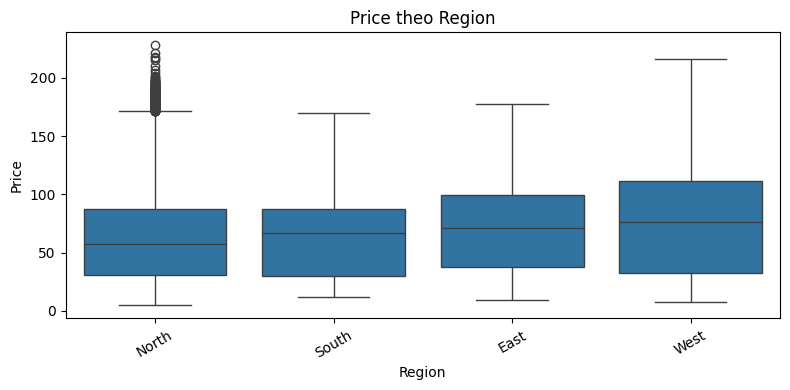

In [20]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x=region_col, y=price_col)
plt.title("Price theo Region")
plt.xlabel("Region")
plt.ylabel("Price")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

  Region  count       mean        std  median
3   West  15200  77.412568  45.469602  76.560
0   East  15200  70.092303  37.159589  71.025
2  South  15200  64.401070  32.352922  66.880
1  North  30400  63.362098  39.432143  57.485


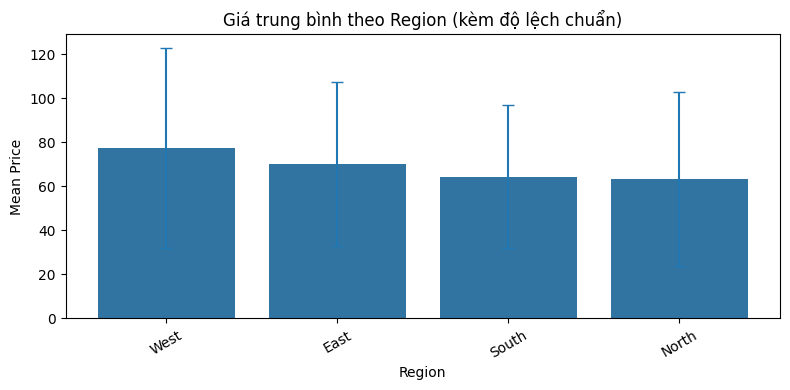

In [21]:
# Mean Price theo Region 
price_by_region = (
    df.groupby(region_col)[price_col]
      .agg(["count", "mean", "std", "median"])
      .reset_index()
      .sort_values("mean", ascending=False)
)

print(price_by_region)

plt.figure(figsize=(8,4))
sns.barplot(data=price_by_region, x=region_col, y="mean", errorbar=None)
# vẽ error bar = std 
plt.errorbar(
    x=np.arange(len(price_by_region)),
    y=price_by_region["mean"].values,
    yerr=price_by_region["std"].fillna(0).values,
    fmt="none",
    capsize=4
)
plt.title("Giá trung bình theo Region (kèm độ lệch chuẩn)")
plt.xlabel("Region")
plt.ylabel("Mean Price")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


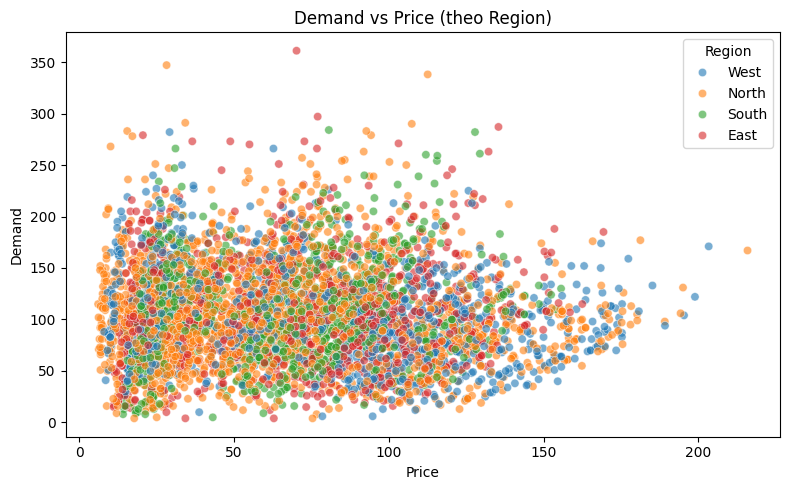

In [22]:
#  Demand vs Price, tô màu theo Region
plt.figure(figsize=(8,5))
sns.scatterplot(data=df.sample(min(len(df), 5000), random_state=42),
                x=price_col, y="Demand", hue=region_col, alpha=0.6)
plt.title("Demand vs Price (theo Region)")
plt.xlabel("Price")
plt.ylabel("Demand")
plt.tight_layout()
plt.show()


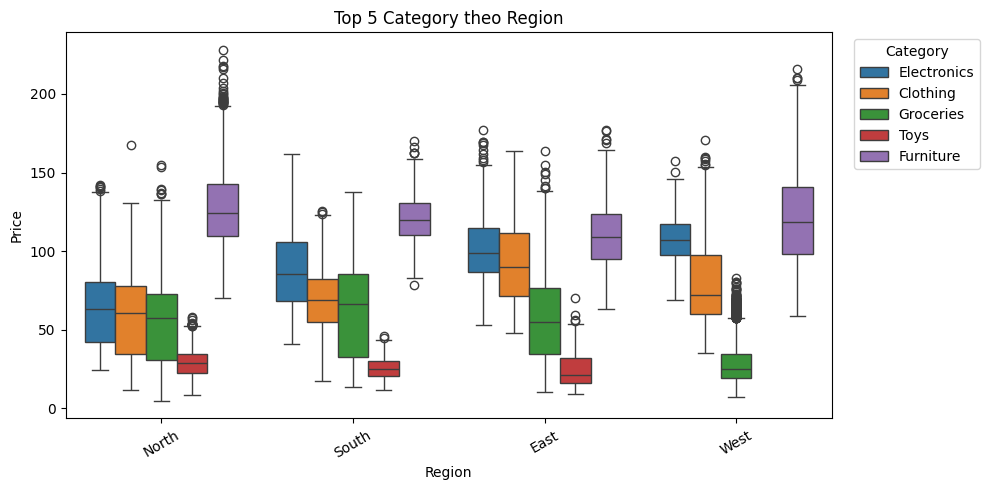

In [23]:
# top 5 Category phổ biến
# so Price theo Region trong từng Category
top_k = 5
top_cats = df["Category"].value_counts().head(top_k).index

tmp = df[df["Category"].isin(top_cats)].copy()

plt.figure(figsize=(10,5))
sns.boxplot(data=tmp, x=region_col, y="Price", hue="Category")
plt.title(f"Top {top_k} Category theo Region")
plt.xlabel("Region")
plt.ylabel("Price")
plt.xticks(rotation=30)
plt.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


Kết luận: 
Promotion làm Demand tăng rõ rệt và tăng mức độ biến động, Epidemic làm Demand giảm mạnh. Seasonality tạo khác biệt nhu cầu theo mùa, còn Region tạo khác biệt nhẹ nhưng ổn định. Do đó, các biến Promotion, Epidemic, Seasonality, Region đều cần được giữ làm đặc trưng đầu vào và là cơ sở để lựa chọn mô hình có khả năng xử lý dữ liệu bảng đa biến và các biến sự kiện.

5.3 Phân tích theo thời gian

Phân tích Demand trung bình theo tháng cho thấy nhu cầu có biến động theo thời gian và dấu hiệu mùa vụ, tuy nhiên không tồn tại xu hướng tăng/giảm tuyến tính. Ngoài ra, một số thời điểm xuất hiện biến động đột ngột, phản ánh tác động của các yếu tố sự kiện như dịch bệnh hoặc khuyến mãi. Do đó, đề tài không lựa chọn các mô hình chuỗi thời gian thuần túy mà ưu tiên các mô hình học máy trên dữ liệu bảng, kết hợp đặc trưng thời gian và biến sự kiện.

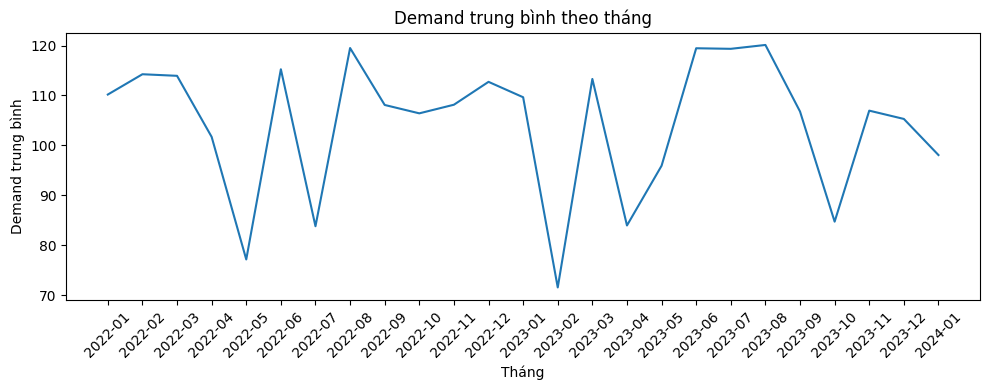

In [24]:
tmp = df.dropna(subset=["Date"]).copy()
tmp["YearMonth"] = tmp["Date"].dt.to_period("M").astype(str)

monthly = tmp.groupby("YearMonth")["Demand"].mean().reset_index()

plt.figure(figsize=(10,4))
plt.plot(monthly["YearMonth"], monthly["Demand"])
plt.title("Demand trung bình theo tháng")
plt.xlabel("Tháng")
plt.ylabel("Demand trung bình")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

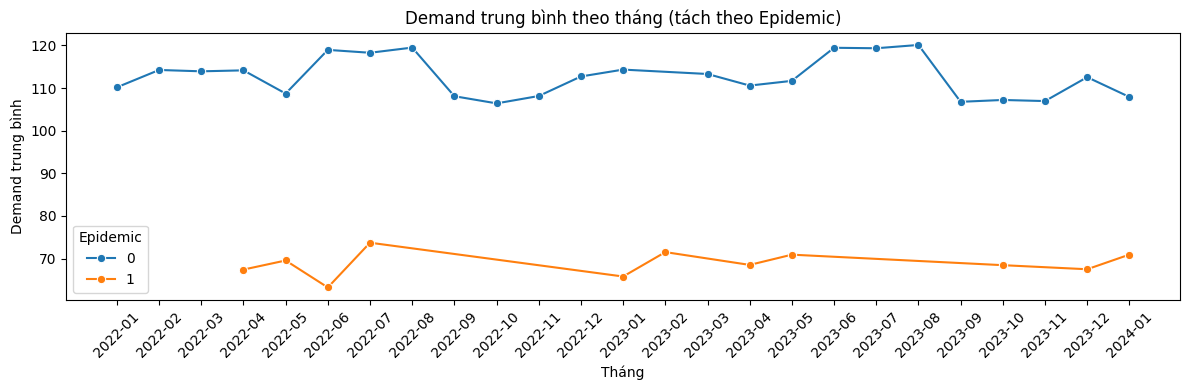

In [25]:
# Monthly Demand theo Epidemic (0/1)
tmp = df.dropna(subset=[date_col]).copy()
tmp["YearMonth"] = tmp[date_col].dt.to_period("M").astype(str)

monthly_ep = (
    tmp.groupby(["YearMonth", "Epidemic"])["Demand"]
       .mean()
       .reset_index()
)

plt.figure(figsize=(12,4))
sns.lineplot(data=monthly_ep, x="YearMonth", y="Demand", hue="Epidemic", marker="o")
plt.title("Demand trung bình theo tháng (tách theo Epidemic)")
plt.xlabel("Tháng")
plt.ylabel("Demand trung bình")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5.4 Ma trận tương quan

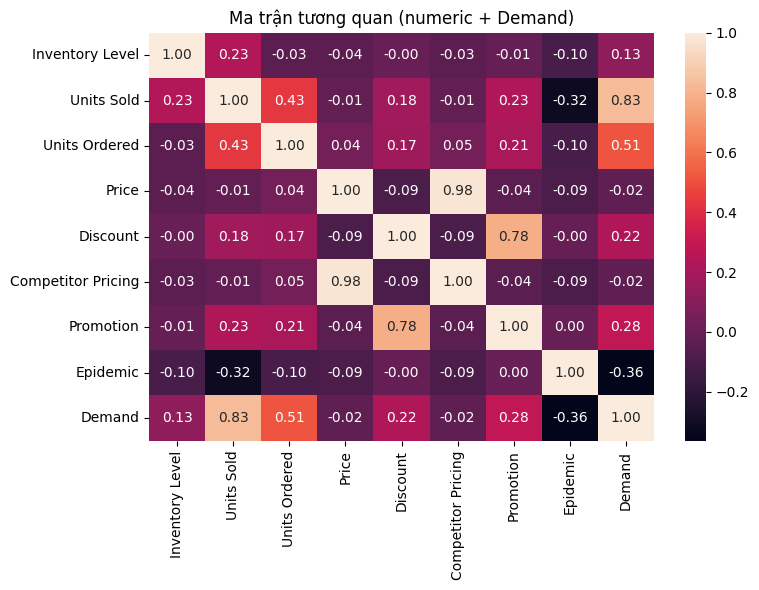

In [26]:
corr_cols = ["Inventory Level","Units Sold","Units Ordered","Price","Discount","Competitor Pricing","Promotion","Epidemic","Demand"]

corr_df = df[corr_cols].copy()

corr_df["Promotion"] = corr_df["Promotion"].astype(int)
corr_df["Epidemic"] = corr_df["Epidemic"].astype(int)

corr = corr_df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Ma trận tương quan (numeric + Demand)")
plt.tight_layout()
plt.show()

- Biến có quan hệ tuyến tính với Demand: Units Sold, Units Ordered, Epidemic
- đa cộng tuyến mạnh: Price - Competitor Pricing, Discount–Promotion.
Ma trận tương quan cho thấy một số biến có quan hệ tuyến tính rõ ràng với Demand, trong khi các biến như Price, Promotion và Discount thể hiện ảnh hưởng phi tuyến hoặc theo điều kiện. Đồng thời, sự tồn tại của đa cộng tuyến mạnh giữa một số feature khiến Linear Regression không còn phù hợp. Do đó, Ridge Regression được lựa chọn để đảm bảo tính ổn định của mô hình tuyến tính, các mô hình phi tuyến như Random Forest được sử dụng cho bài toán phân loại Stockout.

6. Feature Engineering (Bổ sung thông tin thời gian và nghiệp vụ)
6.1 Feature thời gian


In [27]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["DayOfWeek"] = df["Date"].dt.dayofweek   # 0 = Monday
df["IsWeekend"] = df["DayOfWeek"].isin([5,6]).astype(int)
df["Stockout"] = (df["Units Sold"] >= df["Inventory Level"]).astype(int)


In [28]:
df["Effective_Price"] = df["Price"] * (1 - df["Discount"] / 100)
df["Has_Discount"] = (df["Discount"] > 0).astype(int)


In [29]:
df["Promo_Epidemic"] = ((df["Promotion"] == 1) & (df["Epidemic"] == 1)).astype(int)


In [30]:
df["Stockout"] = (df["Units Sold"] >= df["Inventory Level"]).astype(int)

print("Tỷ lệ Stockout:")
print(df["Stockout"].value_counts(normalize=True))


Tỷ lệ Stockout:
Stockout
0    0.886132
1    0.113868
Name: proportion, dtype: float64


In [31]:
#Xóa dòng lỗi ngày
df = df.dropna(subset=["Date"]).copy()

# Sắp xếp theo thời gian
df = df.sort_values("Date").reset_index(drop=True)

print("Khoảng thời gian dữ liệu:")
print("Từ:", df["Date"].min(), "đến:", df["Date"].max())
print("Số dòng:", len(df))


Khoảng thời gian dữ liệu:
Từ: 2022-01-01 00:00:00 đến: 2024-01-30 00:00:00
Số dòng: 76000


In [ ]:
import os

# Lưu dữ liệu đã làm sạch
clean_dir = r"C:\Users\Admin\AdvancedPython\12423030_12423TN_HoangThiMinhTam\data"
os.makedirs(clean_dir, exist_ok=True)

clean_csv_path = os.path.join(clean_dir, "inventory_clean.csv")

df.to_csv(clean_csv_path, index=False)
print("Đã lưu file:", clean_csv_path)
print("Shape:", df.shape)

Đã lưu file: C:\Users\Admin\AdvancedPython\12423030_12423TN_HoangThiMinhTam\data\inventory_clean.csv
Shape: (76000, 24)
